
# EDA (v3) — Diagnóstico profundo + Preparación Linked Data (Melbourne)

**Generado:** 2025-10-10 11:34

Este cuaderno realiza un análisis exhaustivo de:
- **Peatones**: observaciones por hora (`ped_obs`) y ubicaciones (`ped_loc`).
- **Microclima**: **usamos SOLO las ubicaciones presentes en las observaciones** (`mic_obs`), **no** `mic_loc`.
- **Feriados**: tabla de días festivos en Australia, filtrando Melbourne.

Además incorpora **tus decisiones** y hallazgos:
- En `ped_loc`: si hay `sensor_name` repetidos **BirBridge_T** y **Lat526_T**, renombrar con sufijo `_1` y `_2` por localización.
- En `ped_loc.Note`: reemplazar `"<Null>"` por blanco (coherente con otros blanks).
- Eliminar de `ped_loc` las filas con `Direction_1` **y** `Direction_2` en blanco (no aparecen en `ped_obs`).
- En `mic_obs`: reportar NAs específicos por sensor, eliminar registros “inservibles” (todas las variables climáticas nulas; además filas de ICTMicroclimate-10/11 con solo `MinimumWindDirection`).
- **Subset temporal** recomendado: **diciembre 2024** (mes denso y reciente).

El cuaderno Produce:
- Inventario de columnas, tipado **semántico** sugerido (RDF literals), baja cardinalidad, faltantes.
- Duplicados (exactos/por clave) y **clones de entidad**.
- **Proximidad** peatones↔microclima (≤1 km) con **confidence** (`high/medium/low/very_low`).
- **Join temporal** ±30 min entre peatones y microclima (con microclima convertido a `Australia/Melbourne` cuando sea posible).
- **Rangos físicos** para calidad de microclima; **outliers** y **zero-inflation** en peatones.
- Cruce con **feriados (Melbourne)** y ejemplos de **consultas SPARQL**.

> **Objetivo**: dejar claro **qué borrar**, **qué modelar** en Linked Data y **cómo enlazar** las tablas.


In [17]:

# === Parámetros (edita rutas en CANDIDATE_PATHS) ===
CANDIDATE_PATHS = [
    # >>> REEMPLAZA por tus rutas locales, en cualquier orden <<<
    "/content/pedestrian-counting-system-monthly-counts-per-hour.csv",
    "/content/pedestrian-counting-system-sensor-locations_enriched.csv",
    "/content/microclimate-sensors-data (1).csv",
    # "/content/microclimate-sensor-locations_enriched.csv",  # (opcional, NO usado)
    "/content/Public holidays (1).csv",
]

FOCUS_YEAR  = 2024
FOCUS_MONTH = 12  # diciembre 2024
RADIUS_CANDIDATES = [150, 300, 500, 800, 1000]
CLOSE_RADIUS_M = 1000
TOP_N = 25


In [18]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt, re, os, warnings
from math import radians, sin, cos, sqrt, atan2
warnings.filterwarnings("ignore")

def norm(s:str)->str:
    return re.sub(r'[^a-z0-9]', '', str(s).lower())

def load_csv_safe(path):
    try:
        df = pd.read_csv(path)
        df.attrs['__path__'] = path
        return df, None
    except Exception as e:
        return None, f"{path}: {e}"

def signature_score(columns, must_have=None, any_of=None):
    cols = {norm(c) for c in columns}
    score = 0
    if must_have:
        for m in must_have:
            if norm(m) in cols: score += 3
    if any_of:
        for a in any_of:
            if norm(a) in cols: score += 1
    return score

def detect_role(df):
    cols = list(df.columns)
    sigs = {
        "ped_obs": dict(must=["Location_ID","Sensing_Date","HourDay","Total_of_Directions"],
                        any=["Direction_1","Direction_2","Sensor_Name","Location"]),
        "ped_loc": dict(must=["Location_ID","Sensor_Name","Latitude","Longitude"],
                        any=["Sensor_Description","Location_Type","Status","street","postcode","city","country","formatted"]),
        "mic_obs": dict(must=["Device_id","Time"],
                        any=["LatLong","AirTemperature","PM25","PM10","RelativeHumidity","AverageWindSpeed"]),
        "mic_loc": dict(must=["Site_ID","Latitude","Longitude"],
                        any=["Site_Status","Start_Reading","End_Reading","street","postcode","city","country","formatted"]),
        "hol": dict(must=["Date","Year","Month","Day","DOW"],
                    any=["Melbourne","National_holiday","Public holiday"]),
    }
    scores = {role: signature_score(cols, must_have=sig["must"], any_of=sig["any"]) for role, sig in sigs.items()}
    role = max(scores, key=scores.get)
    return role, scores

def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000.0
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

def describe_columns(df):
    out = []
    for c in df.columns:
        s = df[c]
        try:
            smp = ", ".join(map(str, s.dropna().astype(str).head(3).tolist()))
        except Exception:
            smp = ""
        out.append({"column": c, "dtype": str(s.dtype), "n_null": int(s.isna().sum()),
                    "pct_null": float(100*s.isna().mean()), "n_unique": int(s.nunique(dropna=True)),
                    "sample_values": smp})
    return pd.DataFrame(out).sort_values(["pct_null","n_unique"], ascending=[False,True])

def low_card(df, thr=3):
    rows = []
    for c in df.columns:
        n = df[c].nunique(dropna=True)
        if n <= thr:
            rows.append({"column": c, "n_unique": int(n)})
    return pd.DataFrame(rows).sort_values(["n_unique","column"])



## Carga y detección automática de roles

- Pegá las rutas en **CANDIDATE_PATHS** en cualquier orden.
- El cuaderno identifica cada CSV por sus columnas.
- `mic_loc` se puede cargar, pero **no se usa** (usamos `mic_obs` para geolocalización).


In [19]:

loaded, errors = [], []
for p in CANDIDATE_PATHS:
    df, err = load_csv_safe(p)
    if err: errors.append(err)
    else: loaded.append(df)

if errors:
    print("Errores al leer algunos CSV:")
    for e in errors: print(" -", e)

role_map, role_scores = {}, {}
for df in loaded:
    role, scores = detect_role(df)
    path = df.attrs.get('__path__', '<unknown>')
    role_map[role] = df
    role_scores[path] = scores

for r in ["ped_obs","ped_loc","mic_obs","mic_loc","hol"]:
    present = r in role_map
    print(f"{r}: {'OK' if present else 'NO DETECTADO'}")

ped    = role_map.get("ped_obs", pd.DataFrame())
ped_loc= role_map.get("ped_loc", pd.DataFrame())
mic    = role_map.get("mic_obs", pd.DataFrame())
mic_loc= role_map.get("mic_loc", pd.DataFrame())  # cargado pero NO usado
hol    = role_map.get("hol", pd.DataFrame())

for name, df in [("ped_obs", ped), ("ped_loc", ped_loc), ("mic_obs", mic), ("mic_loc", mic_loc), ("hol", hol)]:
    print(f"=== {name} shape={df.shape}")
    display(df.head(3))


ped_obs: OK
ped_loc: OK
mic_obs: OK
mic_loc: NO DETECTADO
hol: OK
=== ped_obs shape=(26720, 9)


,ID,Location_ID,Sensing_Date,HourDay,Direction_1,Direction_2,Total_of_Directions,Sensor_Name,Location
0,12320250113,1,2025-01-13,23.0,32.0,56.0,88.0,Bou292_T,"-37.81349441, 144.96515323"
1,121120241013,12,2024-10-13,11.0,249.0,275.0,524.0,NewQ_T,"-37.81457988, 144.94292398"
2,241020240527,24,2024-05-27,10.0,647.0,409.0,1056.0,Col620_T,"-37.81887963, 144.95449198"


=== ped_loc shape=(143, 18)


,Location_ID,Sensor_Description,Sensor_Name,Installation_Date,Note,Location_Type,Status,Direction_1,Direction_2,Latitude,Longitude,Location,street,housenumber,postcode,city,country,formatted
0,1,Bourke Street Mall (North),Bou292_T,2009-03-24,NaN,Outdoor,A,East,West,-37.813494,144.965153,"-37.81349441, 144.96515323",Bourke Street Mall,280,3000,Melbourne,Australia,"Cue City, 280 Bourke Street Mall, Melbourne VI..."
1,4,Town Hall (West),Swa123_T,2009-03-23,NaN,Outdoor,A,North,South,-37.814880,144.966088,"-37.81487988, 144.9660878",Swanston Street,117,3000,Melbourne,Australia,"117 Swanston Street, Melbourne VIC 3000, Austr..."
2,10,Victoria Point,BouHbr_T,2009-04-23,NaN,Outdoor,A,East,West,-37.818765,144.947105,"-37.81876474, 144.94710545",Bourke Street,770,3008,Docklands,Australia,"770 Bourke Street, Docklands VIC 3008, Australia"


=== mic_obs shape=(12325, 16)


,Device_id,Time,SensorLocation,LatLong,MinimumWindDirection,AverageWindDirection,MaximumWindDirection,MinimumWindSpeed,AverageWindSpeed,GustWindSpeed,AirTemperature,RelativeHumidity,AtmosphericPressure,PM25,PM10,Noise
0,ICTMicroclimate-10,2025-08-17T04:06:40+10:00,1 Treasury Place,"-37.8128595, 144.9745395",4.0,357.0,27.0,0.8,0.8,1.2,4.7,93.900000,1012.700000,10.0,15.0,62.500000
1,ICTMicroclimate-05,2025-08-24T04:58:22+10:00,Enterprize Park - Pole ID: COM1667,"-37.8204083, 144.9591192",0.0,0.0,202.0,0.0,0.0,0.5,8.3,88.400000,1024.400000,11.0,13.0,69.000000
2,ICTMicroclimate-01,2025-08-24T04:57:53+10:00,Birrarung Marr Park - Pole 1131,"-37.8185931, 144.9716404",NaN,70.0,NaN,NaN,0.2,NaN,6.5,97.099998,1023.599976,10.0,13.0,51.400002


=== mic_loc shape=(0, 0)


""


=== hol shape=(459, 16)


,Date,Year,Month,Day,DOW,Public holiday,Adelaide,Brisbane,Canberra,Darwin,Hobart,Melbourne,Perth,Sydney,Number,National_holiday
0,1/1/2004,2004,1,1,Thursday,New Year's Day,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8,True
1,1/26/2004,2004,1,26,Monday,Australia Day,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8,True
2,2/9/2004,2004,2,9,Monday,Royal Hobart Regatta,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1,False



## Resolución de columnas (case-aware) + limpieza mínima de `ped_loc`

Acciones:
1) `Note`: `"<Null>"` → `""`.
2) `sensor_name` duplicados **BirBridge_T** y **Lat526_T** → sufijos `_1`, `_2` por Location_ID (estable).
3) Remover filas con `Direction_1` **y** `Direction_2` en blanco (no aparecen en `ped_obs`).


In [20]:

expected = {
    "ped_obs": ["ID","Location_ID","Sensing_Date","HourDay","Direction_1","Direction_2","Total_of_Directions","Sensor_Name","Location"],
    "ped_loc": ["Location_ID","Sensor_Description","Sensor_Name","Installation_Date","Note","Location_Type","Status",
                "Direction_1","Direction_2","Latitude","Longitude","Location","street","housenumber","postcode","city","country","formatted"],
    "mic_obs": ["Device_id","Time","SensorLocation","LatLong","MinimumWindDirection","AverageWindDirection","MaximumWindDirection",
                "MinimumWindSpeed","AverageWindSpeed","GustWindSpeed","AirTemperature","RelativeHumidity","AtmosphericPressure","PM25","PM10","Noise"],
    "hol": ["Date","Year","Month","Day","DOW","Melbourne","National_holiday","Public holiday","Number"]
}
def resolve(df, keys):
    idx = {norm(c): c for c in df.columns}
    return {k: idx.get(norm(k)) for k in keys}

resolved = {
    "ped_obs": resolve(ped, expected["ped_obs"]) if not ped.empty else {},
    "ped_loc": resolve(ped_loc, expected["ped_loc"]) if not ped_loc.empty else {},
    "mic_obs": resolve(mic, expected["mic_obs"]) if not mic.empty else {},
    "hol":     resolve(hol, expected["hol"]) if not hol.empty else {},
}

for name, m in resolved.items():
    print(f"--- {name} (canónico → real) ---")
    display(pd.DataFrame({"canonical": list(m.keys()), "actual": list(m.values())}))

# Limpieza ped_loc
if not ped_loc.empty and resolved["ped_loc"]:
    c_note = resolved["ped_loc"].get("Note")
    if c_note and c_note in ped_loc.columns:
        ped_loc[c_note] = ped_loc[c_note].replace("<Null>", "").fillna("")

    c_sname = resolved["ped_loc"].get("Sensor_Name")
    c_locid = resolved["ped_loc"].get("Location_ID")
    if c_sname and c_locid and c_sname in ped_loc.columns and c_locid in ped_loc.columns:
        for s in ["BirBridge_T", "Lat526_T"]:
            mask = ped_loc[c_sname]==s
            if mask.sum()>1:
                order = ped_loc.loc[mask, c_locid].sort_values().index
                for k, idx in enumerate(order, start=1):
                    ped_loc.loc[idx, c_sname] = f"{s}_{k}"

    c_d1 = resolved["ped_loc"].get("Direction_1")
    c_d2 = resolved["ped_loc"].get("Direction_2")
    if c_d1 and c_d2 and c_d1 in ped_loc.columns and c_d2 in ped_loc.columns:
        before = len(ped_loc)
        mask_blank = (ped_loc[c_d1].astype(str).str.strip()=="") & (ped_loc[c_d2].astype(str).str.strip()=="")
        ped_loc = ped_loc.loc[~mask_blank].copy()
        print(f"ped_loc: eliminadas {before-len(ped_loc)} filas con Direction_1 & Direction_2 en blanco.")


--- ped_obs (canónico → real) ---


,canonical,actual
0,ID,ID
1,Location_ID,Location_ID
2,Sensing_Date,Sensing_Date
3,HourDay,HourDay
4,Direction_1,Direction_1
5,Direction_2,Direction_2
6,Total_of_Directions,Total_of_Directions
7,Sensor_Name,Sensor_Name
8,Location,Location


--- ped_loc (canónico → real) ---


,canonical,actual
0,Location_ID,Location_ID
1,Sensor_Description,Sensor_Description
2,Sensor_Name,Sensor_Name
3,Installation_Date,Installation_Date
4,Note,Note
5,Location_Type,Location_Type
6,Status,Status
7,Direction_1,Direction_1
8,Direction_2,Direction_2
9,Latitude,Latitude


--- mic_obs (canónico → real) ---


,canonical,actual
0,Device_id,Device_id
1,Time,Time
2,SensorLocation,SensorLocation
3,LatLong,LatLong
4,MinimumWindDirection,MinimumWindDirection
5,AverageWindDirection,AverageWindDirection
6,MaximumWindDirection,MaximumWindDirection
7,MinimumWindSpeed,MinimumWindSpeed
8,AverageWindSpeed,AverageWindSpeed
9,GustWindSpeed,GustWindSpeed


--- hol (canónico → real) ---


,canonical,actual
0,Date,Date
1,Year,Year
2,Month,Month
3,Day,Day
4,DOW,DOW
5,Melbourne,Melbourne
6,National_holiday,National_holiday
7,Public holiday,Public holiday
8,Number,Number


ped_loc: eliminadas 0 filas con Direction_1 & Direction_2 en blanco.



## Limpieza `mic_obs` (según criterios pactados)

- Registros “inservibles”: **todas** las variables climáticas nulas → eliminar.
- Para **ICTMicroclimate-10/11**: filas con **solo** `MinimumWindDirection` y resto nulo → eliminar.
- Reporte de NAs por **sensor** y **variable** (para reflejar patrones como `aws5-0999` y `ICTMicroclimate-01`).


In [21]:

if not mic.empty and resolved["mic_obs"]:
    c_dev = resolved["mic_obs"]["Device_id"]
    cols_clima = [resolved["mic_obs"].get(k) for k in [
        "MinimumWindDirection","AverageWindDirection","MaximumWindDirection",
        "MinimumWindSpeed","AverageWindSpeed","GustWindSpeed",
        "AirTemperature","RelativeHumidity","AtmosphericPressure","PM25","PM10","Noise"
    ] if resolved["mic_obs"].get(k)]
    cols_clima = [c for c in cols_clima if c in mic.columns]

    print("Registros por Device_id (antes):")
    display(mic[c_dev].value_counts().rename_axis("device").reset_index(name="n"))

    all_null = mic[cols_clima].isna().all(axis=1)
    c_minwd = resolved["mic_obs"].get("MinimumWindDirection")
    only_minwd = pd.Series(False, index=mic.index)
    if c_minwd:
        only_minwd = mic[c_minwd].notna() & mic[[c for c in cols_clima if c != c_minwd]].isna().all(axis=1)

    mic_clean = mic.loc[~(all_null | only_minwd)].copy()
    print(f"Eliminados inservibles (todas climáticas nulas): {int(all_null.sum())}")
    print(f"Eliminados 10/11 con solo MinimumWindDirection: {int(only_minwd.sum())}")

    print("Registros por Device_id (después):")
    display(mic_clean[c_dev].value_counts().rename_axis("device").reset_index(name="n"))

    # NAs por variable/sensor
    na_report = []
    for var in ["MinimumWindDirection","MaximumWindDirection","MinimumWindSpeed","GustWindSpeed","PM25","PM10","Noise"]:
        col = resolved["mic_obs"].get(var)
        if col and col in mic_clean.columns:
            grp = mic_clean.groupby(c_dev)[col].apply(lambda s: int(s.isna().sum())).reset_index().rename(columns={col:"n_na"})
            grp["variable"] = var
            na_report.append(grp)
    if na_report:
        na_report = pd.concat(na_report, ignore_index=True)
        display(na_report.pivot_table(index=c_dev, columns="variable", values="n_na", fill_value=0))
else:
    print("mic_obs vacío o sin columnas esperadas.")


Registros por Device_id (antes):


,device,n
0,ICTMicroclimate-07,1396
1,ICTMicroclimate-03,1306
2,ICTMicroclimate-08,1297
3,ICTMicroclimate-06,1296
4,ICTMicroclimate-02,1294
5,ICTMicroclimate-01,1272
6,ICTMicroclimate-09,999
7,ICTMicroclimate-10,903
8,ICTMicroclimate-11,791
9,ICTMicroclimate-05,736


Eliminados inservibles (todas climáticas nulas): 12
Eliminados 10/11 con solo MinimumWindDirection: 0
Registros por Device_id (después):


,device,n
0,ICTMicroclimate-07,1395
1,ICTMicroclimate-03,1303
2,ICTMicroclimate-08,1296
3,ICTMicroclimate-06,1295
4,ICTMicroclimate-02,1294
5,ICTMicroclimate-01,1272
6,ICTMicroclimate-09,998
7,ICTMicroclimate-10,901
8,ICTMicroclimate-11,790
9,ICTMicroclimate-05,735


variable,GustWindSpeed,MaximumWindDirection,MinimumWindDirection,MinimumWindSpeed,Noise,PM10,PM25
Device_id,,,,,,,
ICTMicroclimate-01,1272.0,1272.0,1272.0,1272.0,0.0,0.0,0.0
ICTMicroclimate-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ICTMicroclimate-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ICTMicroclimate-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ICTMicroclimate-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ICTMicroclimate-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ICTMicroclimate-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ICTMicroclimate-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ICTMicroclimate-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0



## Subset temporal: **diciembre 2024** (recomendado)


In [22]:

ped_dec = pd.DataFrame()
mic_dec = pd.DataFrame()
if not ped.empty and resolved["ped_obs"]:
    c_date = resolved["ped_obs"]["Sensing_Date"]
    dt = pd.to_datetime(ped[c_date], errors="coerce")
    ped_dec = ped[(dt.dt.year==FOCUS_YEAR) & (dt.dt.month==FOCUS_MONTH)].copy()
    print("ped_obs Dec 2024:", ped_dec.shape)

if 'mic_clean' in locals() and not mic_clean.empty and resolved["mic_obs"]:
    c_time = resolved["mic_obs"]["Time"]
    t = pd.to_datetime(mic_clean[c_time], errors="coerce", utc=True)
    try:
        t_local = t.dt.tz_convert("Australia/Melbourne")
    except Exception:
        t_local = t.dt.tz_localize(None)
    mic_clean = mic_clean.assign(__local_dt=t_local)
    mic_dec = mic_clean[(t_local.dt.year==FOCUS_YEAR) & (t_local.dt.month==FOCUS_MONTH)].copy()
    print("mic_obs Dec 2024:", mic_dec.shape)


ped_obs Dec 2024: (1145, 9)
mic_obs Dec 2024: (418, 17)



## Inventario, baja cardinalidad y faltantes (dic-2024)

Interpretación (Linked Data):
- **Constantes**: van al nivel sitio/dataset, no por observación.
- **Baja cardinalidad**: candidatas a SKOS.
- **Faltantes**: propiedades **opcionales** o anotar calidad (DQV).


In [23]:
# --- Parches robustos ---

def low_card(df: pd.DataFrame, thr: int = 3) -> pd.DataFrame:
    """
    Devuelve un DataFrame con columnas ['column','n_unique'] (aunque no haya filas).
    Evita KeyError al ordenar/mostrar cuando df está vacío o no hay columnas <= thr.
    """
    if df is None or df.empty:
        return pd.DataFrame(columns=["column", "n_unique"])

    rows = []
    for c in df.columns:
        try:
            n = df[c].nunique(dropna=True)
            if n <= thr:
                rows.append({"column": c, "n_unique": int(n)})
        except Exception:
            # Si alguna columna da error al calcular nunique, la saltamos
            continue

    out = pd.DataFrame(rows, columns=["column", "n_unique"])
    if out.empty:
        return out  # ya tiene las columnas correctas
    return out.sort_values(by=["n_unique", "column"], ascending=True).reset_index(drop=True)


def miss(df: pd.DataFrame) -> pd.Series:
    """
    Devuelve % de nulos por columna. Si df está vacío, devuelve Serie vacía.
    """
    if df is None or df.empty:
        return pd.Series(dtype=float)
    return (df.isna().mean() * 100).sort_values(ascending=False).round(2)


# --- Uso seguro en tu bucle actual ---

for name, df in [
    ("ped_obs (dic-24)", ped_dec),
    ("ped_loc (limpio)", ped_loc),
    ("mic_obs (dic-24, limpio)", mic_dec),
]:
    print(f"### {name} — shape={df.shape}")
    if df is None or df.empty:
        print("Tabla vacía.")
        continue

    display(describe_columns(df))

    print("Baja cardinalidad ≤3:")
    lc = low_card(df)
    # Mostrar un DF vacío con las columnas correctas si no hay filas
    display(lc if not lc.empty else pd.DataFrame(columns=["column", "n_unique"]))

    print("Faltantes Top 20:")
    m = miss(df)
    display(m.head(20) if not m.empty else pd.Series(dtype=float))


### ped_obs (dic-24) — shape=(1145, 9)


,column,dtype,n_null,pct_null,n_unique,sample_values
3,HourDay,float64,0,0.0,24,"10.0, 17.0, 6.0"
2,Sensing_Date,object,0,0.0,31,"2024-12-15, 2024-12-21, 2024-12-28"
7,Sensor_Name,object,0,0.0,92,"EntPark1671_T, Eli250_T, 488Mac_T"
1,Location_ID,int64,0,0.0,94,"138, 47, 85"
8,Location,object,0,0.0,94,"-37.81996544, 144.95981454, -37.81258467, 144...."
4,Direction_1,float64,0,0.0,415,"4.0, 1216.0, 5.0"
5,Direction_2,float64,0,0.0,425,"7.0, 997.0, 3.0"
6,Total_of_Directions,float64,0,0.0,571,"11.0, 2213.0, 8.0"
0,ID,int64,0,0.0,1145,"1381020241215, 471720241221, 85620241228"


Baja cardinalidad ≤3:


,column,n_unique


Faltantes Top 20:


,0
ID,0.0
Location_ID,0.0
Sensing_Date,0.0
HourDay,0.0
Direction_1,0.0
Direction_2,0.0
Total_of_Directions,0.0
Sensor_Name,0.0
Location,0.0


### ped_loc (limpio) — shape=(143, 18)


,column,dtype,n_null,pct_null,n_unique,sample_values
7,Direction_1,object,32,22.377622,3,"East, North, East"
8,Direction_2,object,32,22.377622,4,"West, South, West"
13,housenumber,object,4,2.797203,109,"280, 117, 770"
6,Status,object,0,0.000000,1,"A, A, A"
16,country,object,0,0.000000,1,"Australia, Australia, Australia"
5,Location_Type,object,0,0.000000,2,"Outdoor, Outdoor, Outdoor"
14,postcode,int64,0,0.000000,10,"3000, 3000, 3008"
15,city,object,0,0.000000,10,"Melbourne, Melbourne, Docklands"
4,Note,object,0,0.000000,21,", ,"
12,street,object,0,0.000000,47,"Bourke Street Mall, Swanston Street, Bourke St..."


Baja cardinalidad ≤3:


,column,n_unique
0,Status,1
1,country,1
2,Location_Type,2
3,Direction_1,3


Faltantes Top 20:


,0
Direction_1,22.38
Direction_2,22.38
housenumber,2.80
Location_ID,0.00
Sensor_Description,0.00
Sensor_Name,0.00
Location_Type,0.00
Note,0.00
Status,0.00
Installation_Date,0.00


### mic_obs (dic-24, limpio) — shape=(418, 17)


,column,dtype,n_null,pct_null,n_unique,sample_values
7,MinimumWindSpeed,float64,34,8.133971,29,"0.0, 0.0, 0.0"
4,MinimumWindDirection,float64,34,8.133971,56,"0.0, 0.0, 0.0"
9,GustWindSpeed,float64,34,8.133971,86,"3.1, 3.2, 1.1"
6,MaximumWindDirection,float64,34,8.133971,103,"359.0, 356.0, 350.0"
13,PM25,float64,11,2.631579,15,"2.0, 3.0, 4.0"
14,PM10,float64,11,2.631579,19,"2.0, 3.0, 4.0"
15,Noise,float64,11,2.631579,246,"61.1, 64.3, 64.4"
2,SensorLocation,object,0,0.000000,11,Tram Stop 7B - Melbourne Tennis Centre Precinc...
0,Device_id,object,0,0.000000,12,"ICTMicroclimate-06, ICTMicroclimate-08, ICTMic..."
3,LatLong,object,0,0.000000,12,"-37.8194993, 144.9787211, -37.8184515, 144.967..."


Baja cardinalidad ≤3:


,column,n_unique


Faltantes Top 20:


,0
MinimumWindDirection,8.13
MinimumWindSpeed,8.13
MaximumWindDirection,8.13
GustWindSpeed,8.13
PM25,2.63
Noise,2.63
PM10,2.63
Device_id,0.00
Time,0.00
AverageWindSpeed,0.00



## Columnas repetidas/equivalentes

Acción: **unificar** o mapear a la **misma propiedad RDF** si son equivalentes.


In [24]:

def repeated_columns_report(df):
    rep = []
    cols = list(df.columns)
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            a, b = cols[i], cols[j]
            s1, s2 = df[a], df[b]
            eq_exact = (s1.fillna("__NA__").astype(str).values == s2.fillna("__NA__").astype(str).values).all()
            n1 = s1.astype(str).str.strip().str.lower().replace("nan","", regex=False)
            n2 = s2.astype(str).str.strip().str.lower().replace("nan","", regex=False)
            eq_norm  = (n1.fillna("").values == n2.fillna("").values).all()
            if eq_exact or eq_norm:
                rep.append({"col_a": a, "col_b": b, "equal_exact": bool(eq_exact), "equal_normalized": bool(eq_norm)})
    return pd.DataFrame(rep)

for name, df in [("ped_obs dic-24", ped_dec), ("ped_loc", ped_loc), ("mic_obs dic-24", mic_dec)]:
    print(f"### {name}")
    if df.empty: print("Tabla vacía."); continue
    out = repeated_columns_report(df)
    if out.empty: print("Sin columnas repetidas/equivalentes.")
    else: display(out.head(50))


### ped_obs dic-24
Sin columnas repetidas/equivalentes.
### ped_loc
Sin columnas repetidas/equivalentes.
### mic_obs dic-24
Sin columnas repetidas/equivalentes.



## Duplicados (exactos/clave) y **clones de entidad**

- **Por clave**: `ped_obs` (Location_ID, Sensing_Date, HourDay), `mic_obs` (Device_id, Time).
- **Clones**: sitios con mismos atributos salvo ID → consolidar o `owl:sameAs`.


In [34]:

# Duplicados exactos
def full_dups(df): return df[df.duplicated(keep=False)]
print("Duplicados exactos — ped_obs"); display(full_dups(ped).head(TOP_N))
print("Duplicados exactos — mic_obs"); display(full_dups(mic).head(TOP_N))

# Por clave lógica
pkey = [resolved["ped_obs"].get("Location_ID"), resolved["ped_obs"].get("Sensing_Date"), resolved["ped_obs"].get("HourDay")]
pkey = [k for k in pkey if k]
if len(pkey)==3 and all(k in ped.columns for k in pkey):
    dups_key = ped[ped.duplicated(subset=pkey, keep=False)].sort_values(pkey)
    print("Duplicados por (Location_ID, Sensing_Date, HourDay) — ped_obs")
    display(dups_key.head(TOP_N))

mkey = [resolved["mic_obs"].get("Device_id"), resolved["mic_obs"].get("Time")]
mkey = [k for k in mkey if k]
if len(mkey)==2 and all(k in mic.columns for k in mkey):
    dups_m = mic[mic.duplicated(subset=mkey, keep=False)].sort_values(mkey)
    print("Duplicados por (Device_id, Time) — mic_obs")
    display(dups_m.head(TOP_N))

# Clones de entidad (misma info, ID distinto)
if not ped_loc.empty and resolved["ped_loc"].get("Location_ID"):
    cols = [c for c in ped_loc.columns if c not in [resolved["ped_loc"]["Location_ID"], resolved["ped_loc"].get("Sensor_Name",""), resolved["ped_loc"].get("Sensor_Description","")]]
    dup_entities = ped_loc[ped_loc.duplicated(subset=cols, keep=False)].sort_values(cols)
    print("Ubicaciones de peatones con mismos atributos pero distinto ID (posible clon):")
    display(dup_entities.head(TOP_N))

if not mic_loc.empty and resolved["mic_loc"].get("Site_ID"):
    cols = [c for c in mic_loc.columns if c not in [resolved["mic_loc"]["Site_ID"]]]
    dup_entities_m = mic_loc[mic_loc.duplicated(subset=cols, keep=False)].sort_values(cols)
    print("Ubicaciones de microclima con mismos atributos pero distinto Site_ID (posible clon):")
    display(dup_entities_m.head(TOP_N))

# Microclima: “Device distinto, resto igual” en una observación
if len(mkey)==2:
    cols_except_dev = [c for c in mic.columns if c != resolved["mic_obs"]["Device_id"]]
    grp = mic.groupby(cols_except_dev, dropna=False).agg(n_devices=(resolved["mic_obs"]["Device_id"], "nunique")).reset_index()
    same_others = grp[grp["n_devices"] > 1].sort_values("n_devices", ascending=False)
    print("Mismas mediciones exactas con múltiples Device_id — revisar")
    display(same_others.head(TOP_N))


Duplicados exactos — ped_obs


,ID,Location_ID,Sensing_Date,HourDay,Direction_1,Direction_2,Total_of_Directions,Sensor_Name,Location


Duplicados exactos — mic_obs


,Device_id,Time,SensorLocation,LatLong,MinimumWindDirection,AverageWindDirection,MaximumWindDirection,MinimumWindSpeed,AverageWindSpeed,GustWindSpeed,AirTemperature,RelativeHumidity,AtmosphericPressure,PM25,PM10,Noise


Duplicados por (Location_ID, Sensing_Date, HourDay) — ped_obs


,ID,Location_ID,Sensing_Date,HourDay,Direction_1,Direction_2,Total_of_Directions,Sensor_Name,Location


Duplicados por (Device_id, Time) — mic_obs


,Device_id,Time,SensorLocation,LatLong,MinimumWindDirection,AverageWindDirection,MaximumWindDirection,MinimumWindSpeed,AverageWindSpeed,GustWindSpeed,AirTemperature,RelativeHumidity,AtmosphericPressure,PM25,PM10,Noise
2241,ICTMicroclimate-05,2025-07-30T00:53:00+10:00,Enterprize Park - Pole ID: COM1667,"-37.8204083, 144.9591192",179.0,190.0,213.0,0.3,0.6,1.0,10.1,94.2,1015.8,7.0,10.0,67.5
2242,ICTMicroclimate-05,2025-07-30T00:53:00+10:00,Enterprize Park - Pole ID: COM1667,"-37.8204083, 144.9591192",0.0,4.0,202.0,0.0,0.1,0.4,10.4,93.7,1015.8,5.0,7.0,68.2
1041,ICTMicroclimate-06,2025-07-27T15:06:40+10:00,Tram Stop 7B - Melbourne Tennis Centre Precinc...,"-37.8194993, 144.9787211",0.0,45.0,359.0,0.0,1.8,6.1,13.5,70.4,997.3,0.0,0.0,66.4
1042,ICTMicroclimate-06,2025-07-27T15:06:40+10:00,Tram Stop 7B - Melbourne Tennis Centre Precinc...,"-37.8194993, 144.9787211",0.0,348.0,359.0,0.0,0.7,5.4,13.6,69.9,997.1,0.0,0.0,72.1
3697,ICTMicroclimate-07,2025-08-01T18:03:54+10:00,Tram Stop 7C - Melbourne Tennis Centre Precinc...,"-37.8222341, 144.9829409",0.0,0.0,357.0,0.0,0.0,2.0,11.2,79.3,1027.3,3.0,3.0,67.5
3698,ICTMicroclimate-07,2025-08-01T18:03:54+10:00,Tram Stop 7C - Melbourne Tennis Centre Precinc...,"-37.8222341, 144.9829409",0.0,0.0,352.0,0.0,0.0,1.7,11.2,79.7,1027.5,3.0,3.0,76.0
8142,ICTMicroclimate-08,2024-07-15T15:47:54+10:00,Swanston St - Tram Stop 13 adjacent Federation...,"-37.8184515, 144.9678474",0.0,306.0,359.0,0.0,1.9,6.6,10.3,80.0,1002.9,1.0,7.0,73.3
8143,ICTMicroclimate-08,2024-07-15T15:47:54+10:00,Swanston St - Tram Stop 13 adjacent Federation...,"-37.8184515, 144.9678474",0.0,314.0,357.0,0.0,1.8,8.0,10.4,79.5,1002.9,1.0,7.0,74.9
768,ICTMicroclimate-08,2025-07-26T17:35:20+10:00,Swanston St - Tram Stop 13 adjacent Federation...,"-37.8184515, 144.9678474",0.0,293.0,359.0,0.0,1.5,5.6,13.2,73.2,996.7,2.0,2.0,72.3
769,ICTMicroclimate-08,2025-07-26T17:35:20+10:00,Swanston St - Tram Stop 13 adjacent Federation...,"-37.8184515, 144.9678474",0.0,0.0,359.0,0.0,2.3,6.4,13.1,72.7,996.9,2.0,2.0,72.8


Ubicaciones de peatones con mismos atributos pero distinto ID (posible clon):


,Location_ID,Sensor_Description,Sensor_Name,Installation_Date,Note,Location_Type,Status,Direction_1,Direction_2,Latitude,Longitude,Location,street,housenumber,postcode,city,country,formatted


Mismas mediciones exactas con múltiples Device_id — revisar


,Time,SensorLocation,LatLong,MinimumWindDirection,AverageWindDirection,MaximumWindDirection,MinimumWindSpeed,AverageWindSpeed,GustWindSpeed,AirTemperature,RelativeHumidity,AtmosphericPressure,PM25,PM10,Noise,n_devices



## Proximidad peatones ↔ microclima (≤1 km) **usando coordenadas de mic_obs**

- No usamos `mic_loc`. Tomamos `LatLong` de `mic_obs dic-2024`, calculamos **mediana** por `Device_id` y medimos distancia a cada `ped_loc`.
- Asignamos `link_confidence` según **150/300/500/1000 m**.


In [26]:

pairs = pd.DataFrame()
if not ped_loc.empty and not mic_dec.empty and resolved["ped_loc"] and resolved["mic_obs"]:
    plat, plon = resolved["ped_loc"].get("Latitude"), resolved["ped_loc"].get("Longitude")
    plink = resolved["ped_loc"].get("Location_ID")
    c_ll = resolved["mic_obs"].get("LatLong")
    c_dev = resolved["mic_obs"].get("Device_id")

    if plat and plon and c_ll and c_dev and c_ll in mic_dec.columns:
        lat = mic_dec[c_ll].astype(str).str.extract(r'(-?\d+\.?\d*)')[0].astype(float)
        lon = mic_dec[c_ll].astype(str).str.extract(r',\s*(-?\d+\.?\d*)')[0].astype(float)
        mic_xyz = mic_dec.assign(__lat=lat, __lon=lon).dropna(subset=["__lat","__lon"])

        site_mic = mic_xyz.groupby(c_dev, as_index=False).agg(lat=("__lat","median"), lon=("__lon","median"))
        A = ped_loc[[plink, plat, plon, resolved["ped_loc"].get("Sensor_Name","")]].dropna(subset=[plat, plon]).copy()
        rows = []
        a_lat, a_lon = A[plat].to_numpy(), A[plon].to_numpy()
        for i in range(len(A)):
            d = haversine_m(a_lat[i], a_lon[i], site_mic["lat"].values, site_mic["lon"].values)
            idx = np.where(d <= CLOSE_RADIUS_M)[0]
            for j in idx:
                rows.append({
                    "ped_location_id": A.iloc[i][plink],
                    "ped_sensor_name": A.iloc[i][resolved["ped_loc"].get("Sensor_Name","")],
                    "micro_device_id": site_mic.iloc[j][c_dev],
                    "distance_m": float(d[j]),
                })
        pairs = pd.DataFrame(rows).sort_values("distance_m")

        def conf(d):
            if d <= 150: return "high"
            if d <= 300: return "medium"
            if d <= 500: return "low"
            return "very_low"

        if not pairs.empty:
            pairs["link_confidence"] = pairs["distance_m"].apply(conf)
            n_ped_total = A[plink].nunique()
            n_ped_within = pairs["ped_location_id"].nunique()
            print(f"Sensores peatón con ≥1 microclima a ≤1 km: {n_ped_within}/{n_ped_total} ({100*n_ped_within/n_ped_total:.2f}%)")
            display(pairs.head(TOP_N))
        else:
            print("Sin pares a ≤1 km en dic-24.")
    else:
        print("Faltan columnas de coordenadas.")
else:
    print("No hay datos suficientes para proximidad.")


Sensores peatón con ≥1 microclima a ≤1 km: 89/135 (65.93%)


,ped_location_id,ped_sensor_name,micro_device_id,distance_m,link_confidence
439,161,BirArt1109_T,ICTMicroclimate-01,30.083907,high
273,5,PriNW_T,ICTMicroclimate-08,32.457835,high
239,143,Spencer_T,ICTMicroclimate-04,76.424301,high
113,138,EntPark1671_T,ICTMicroclimate-05,78.455828,high
117,141,474Fl_T,ICTMicroclimate-05,83.194276,high
191,63,Bou231_T,ICTMicroclimate-03,90.823746,high
26,39,AlfPl_T,ICTMicroclimate-02,94.568448,high
34,45,Swa148_T,ICTMicroclimate-03,104.865860,high
215,99,TownVis_T,ICTMicroclimate-03,112.771406,high
233,131,King2_T,ICTMicroclimate-05,139.122844,high



## Enlace temporal ±30 min (dic-2024) y correlación

- Para cada observación peatonal (timestamp local a partir de fecha+hora), buscamos el **microclima más cercano en tiempo** (±30’) de los **devices enlazados ≤500 m**.
- Calculamos correlación hora a hora **peatones vs temperatura** (si está disponible).


Correlación día a día (peatones vs temperatura) = 0.424


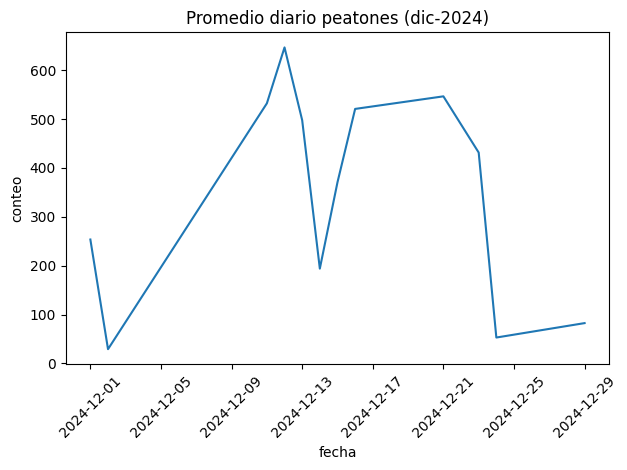

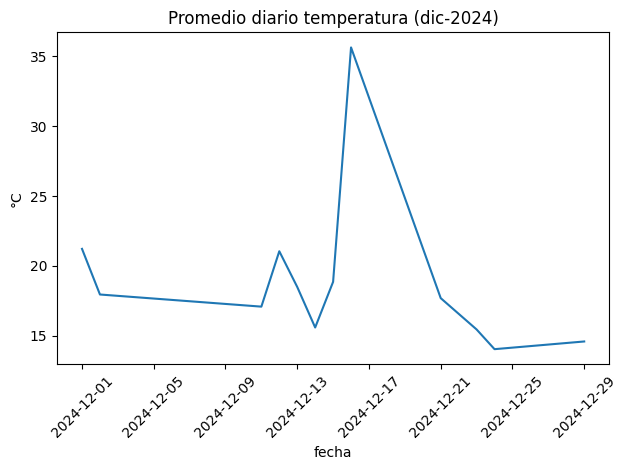

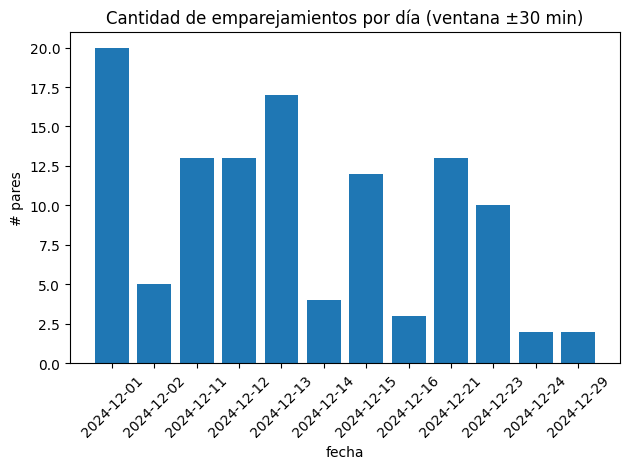

In [28]:
# Promedios **diarios** (en vez de horarios) y correlación día a día — FIX dtype tz-aware vs naive
from datetime import timedelta

corr_report_daily = None

if (
    not ped_dec.empty and not mic_dec.empty
    and resolved["ped_obs"] and resolved["mic_obs"]
    and 'pairs' in locals() and not pairs.empty
):
    p_date = resolved["ped_obs"]["Sensing_Date"]
    p_hour = resolved["ped_obs"]["HourDay"]
    p_count= resolved["ped_obs"]["Total_of_Directions"]
    c_time = resolved["mic_obs"]["Time"]
    c_dev  = resolved["mic_obs"]["Device_id"]
    c_temp = resolved["mic_obs"].get("AirTemperature")

    strong = pairs[pairs["link_confidence"].isin(["high","medium","low"]) & (pairs["distance_m"] <= 500)]
    if strong.empty:
        print("No hay enlaces fuertes (≤500 m).")
    else:
        # --- Peatones: construir timestamp local y asegurar naive (sin tz)
        ped_dt = pd.to_datetime(ped_dec[p_date], errors="coerce")
        ped_ts = pd.to_datetime(
            ped_dt.dt.date.astype(str) + " " + ped_dec[p_hour].astype(str) + ":00:00",
            errors="coerce"
        )
        ped_sub = (
            pd.DataFrame({
                "Location_ID": ped_dec[resolved["ped_obs"]["Location_ID"]],
                "t_local": ped_ts,
                "count": pd.to_numeric(ped_dec[p_count], errors="coerce")
            })
            .dropna(subset=["t_local", "count"])
        )
        ped_sub["t_local"] = pd.to_datetime(ped_sub["t_local"], errors="coerce")  # naive
        ped_sub = ped_sub[ped_sub["Location_ID"].isin(strong["ped_location_id"])].sort_values("t_local")

        # --- Microclima: pasar a Australia/Melbourne y luego quitar tz para que sea naive
        mic_sub = mic_dec[mic_dec[c_dev].isin(strong["micro_device_id"])].copy()
        t_utc = pd.to_datetime(mic_sub[c_time], errors="coerce", utc=True)
        mic_sub["t_local"] = t_utc.dt.tz_convert("Australia/Melbourne")
        mic_sub["t_local"] = mic_sub["t_local"].dt.tz_localize(None)  # <-- KEY: volverla naive
        mic_sub = (
            mic_sub[["t_local", c_temp]]
            .rename(columns={c_temp: "temp"})
            .dropna(subset=["t_local", "temp"])
            .sort_values("t_local")
        )

        if mic_sub.empty or ped_sub.empty:
            print("Sin datos suficientes tras el filtrado por enlaces fuertes.")
        else:
            # Emparejar por tiempo cercano (±30 min) usando merge_asof (ambas columnas son datetime64[ns] naive)
            delta = pd.Timedelta(minutes=30)
            matched = pd.merge_asof(
                ped_sub.sort_values("t_local"),
                mic_sub.sort_values("t_local"),
                on="t_local", direction="nearest", tolerance=delta
            ).dropna(subset=["temp"])

            if matched.empty:
                print("Sin pares temporales ±30 min con temperatura válida.")
            else:
                matched["date"] = matched["t_local"].dt.normalize()
                daily = matched.groupby("date").agg(
                    ped_mean=("count", "mean"),
                    temp_mean=("temp", "mean"),
                    n_obs=("count", "size")
                ).reset_index()

                if len(daily) >= 2:
                    corr_daily = daily[["ped_mean", "temp_mean"]].corr().iloc[0, 1]
                    corr_report_daily = float(corr_daily)
                    print(f"Correlación día a día (peatones vs temperatura) = {corr_daily:.3f}")
                else:
                    print("Muy pocos días para calcular correlación.")

                # Gráficos diarios (matplotlib puro)
                plt.figure()
                plt.plot(daily["date"], daily["ped_mean"])
                plt.title("Promedio diario peatones (dic-2024)")
                plt.xlabel("fecha"); plt.ylabel("conteo"); plt.xticks(rotation=45)
                plt.tight_layout(); plt.show()

                plt.figure()
                plt.plot(daily["date"], daily["temp_mean"])
                plt.title("Promedio diario temperatura (dic-2024)")
                plt.xlabel("fecha"); plt.ylabel("°C"); plt.xticks(rotation=45)
                plt.tight_layout(); plt.show()

                plt.figure()
                plt.bar(daily["date"].astype(str), daily["n_obs"])
                plt.title("Cantidad de emparejamientos por día (ventana ±30 min)")
                plt.xlabel("fecha"); plt.ylabel("# pares"); plt.xticks(rotation=45)
                plt.tight_layout(); plt.show()
else:
    print("Faltan datos para emparejar temporalmente.")



## Outliers y zero-inflation (peatones)

- Confirmamos si **no hay ceros** (coherente con que no se guarda si count=0).
- Outliers con |z|>4 para entender extremos.


Zero-rate (dic-24): 0.00% — esperado ≈ 0% (no se guardan ceros)
Outliers |z|>4: 14


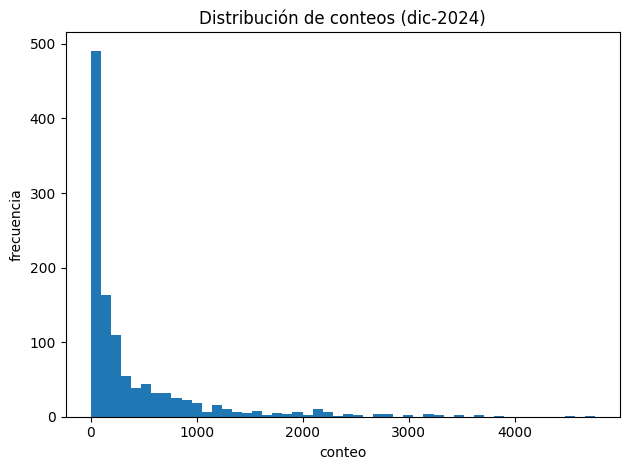

In [29]:

if not ped_dec.empty and resolved["ped_obs"]:
    c_tot = resolved["ped_obs"]["Total_of_Directions"]
    x = pd.to_numeric(ped_dec[c_tot], errors="coerce")
    zeros_rate = (x==0).mean()*100
    mu, sd = x.mean(), x.std()
    z = (x - mu) / (sd if sd>0 else 1)
    outliers = ped_dec[np.abs(z) > 4]
    print(f"Zero-rate (dic-24): {zeros_rate:.2f}% — esperado ≈ 0% (no se guardan ceros)")
    print(f"Outliers |z|>4: {len(outliers)}")
    plt.figure(); plt.hist(x.dropna(), bins=50); plt.title("Distribución de conteos (dic-2024)"); plt.xlabel("conteo"); plt.ylabel("frecuencia"); plt.tight_layout(); plt.show()



## Sanidad de rangos (microclima)

- Chequeos físicos básicos (ej. `0≤RH≤100`, temperatura razonable, PM/ruido no negativos, etc.).
- Acción: limpiar o anotar con DQV cuando exceden rangos.


In [30]:

if not mic_dec.empty and resolved["mic_obs"]:
    checks = []
    def range_check(name, series, lo, hi):
        s = pd.to_numeric(series, errors="coerce")
        frac = ((s<lo)|(s>hi)).mean()*100
        return {"var": name, "pct_outside":round(frac,2), "n": int(s.notna().sum()), "range": f"[{lo},{hi}]"}
    vars_ranges = {
        "AirTemperature": (-10, 50),
        "RelativeHumidity": (0, 100),
        "PM25": (0, 500),
        "PM10": (0, 600),
        "AverageWindSpeed": (0, 40),
        "GustWindSpeed": (0, 60),
        "AtmosphericPressure": (900, 1100),
        "Noise": (0, 130),
    }
    for v,(lo,hi) in vars_ranges.items():
        col = resolved["mic_obs"].get(v)
        if col and col in mic_dec.columns:
            checks.append(range_check(v, mic_dec[col], lo, hi))
    if checks:
        display(pd.DataFrame(checks))


,var,pct_outside,n,range
0,AirTemperature,0.0,418,"[-10,50]"
1,RelativeHumidity,0.0,418,"[0,100]"
2,PM25,0.0,407,"[0,500]"
3,PM10,0.0,407,"[0,600]"
4,AverageWindSpeed,0.0,418,"[0,40]"
5,GustWindSpeed,0.0,384,"[0,60]"
6,AtmosphericPressure,0.0,418,"[900,1100]"
7,Noise,0.0,407,"[0,130]"



## Efecto de feriados (Melbourne)

- Comparamos conteo promedio peatonal entre **feriados** y **no feriados** en dic-2024.


,__is_holiday,mean,median,std,count
0,Weekday,392.379039,145.0,624.29116,1145


Feriados detectados en ped_dec (dic-2024): 0 observaciones


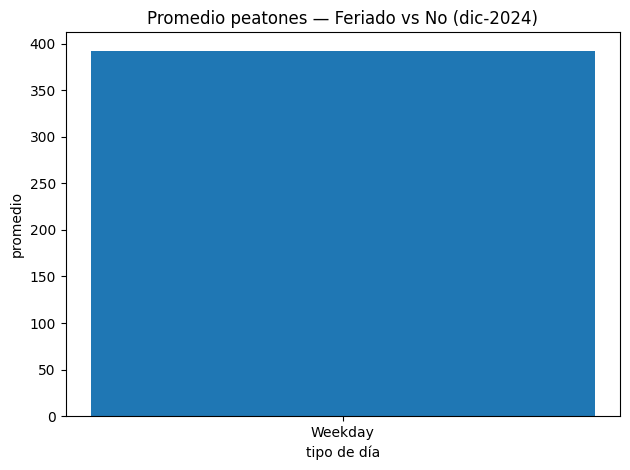

In [32]:
# ==== Cruce Peatones vs Feriados (robusto) ====
# Reconoce feriados de Melbourne aunque la columna tenga 1/True/"TRUE"/"1" y fechas en m/d/Y o Y-m-d

if not hol.empty and not ped_dec.empty and resolved.get("hol") and resolved.get("ped_obs"):
    h_date = resolved["hol"].get("Date")
    h_melb = resolved["hol"].get("Melbourne")
    c_date = resolved["ped_obs"].get("Sensing_Date")
    c_tot  = resolved["ped_obs"].get("Total_of_Directions")

    if h_date and h_melb and c_date and c_tot:

        holix = hol.copy()

        # 1) Normalizar flag Melbourne a booleano
        #    Considera 1, "1", True, "TRUE", "Y", "YES" como feriado
        def to_bool(x):
            if pd.isna(x): return False
            s = str(x).strip().upper()
            return s in {"1", "TRUE", "Y", "YES"}
        holix["__melb"] = holix[h_melb].apply(to_bool)

        # 2) Parseo de fecha: primero m/d/Y, si falla mucho intenta libre
        holix["__date"] = pd.to_datetime(holix[h_date], errors="coerce", format="%m/%d/%Y")
        if holix["__date"].isna().mean() > 0.5:
            holix["__date"] = pd.to_datetime(holix[h_date], errors="coerce")

        # 3) Conjunto de fechas feriado (date puro, sin tz)
        hol_set = set(holix.loc[holix["__melb"] & holix["__date"].notna(), "__date"].dt.normalize().dt.date)

        # 4) Fechas de peatones (date puro)
        pdt = pd.to_datetime(ped_dec[c_date], errors="coerce")
        ped_dec["__date_only"]   = pdt.dt.normalize().dt.date
        ped_dec["__is_holiday"]  = ped_dec["__date_only"].isin(hol_set)

        # 5) Reporte + sanity checks
        comp = (
            ped_dec.groupby("__is_holiday")[c_tot]
            .agg(mean="mean", median="median", std="std", count="count")
            .reset_index()
        )
        comp["__is_holiday"] = comp["__is_holiday"].map({True: "Holiday", False: "Weekday"})
        display(comp)

        # Debug: mostrar feriados encontrados en el mes de análisis (dic-2024) y cuántas obs caen allí
        month_mask = pd.to_datetime(ped_dec[c_date], errors="coerce").dt.month.eq(12) & \
                     pd.to_datetime(ped_dec[c_date], errors="coerce").dt.year.eq(2024)
        ped_dec["__in_dec2024"] = month_mask
        n_hol_in_month = ped_dec.loc[ped_dec["__in_dec2024"], "__is_holiday"].sum()
        print(f"Feriados detectados en ped_dec (dic-2024): {int(n_hol_in_month)} observaciones")

        # Gráfico simple
        plt.figure()
        plt.bar(comp['__is_holiday'].astype(str), comp['mean'])
        plt.title("Promedio peatones — Feriado vs No (dic-2024)")
        plt.xlabel("tipo de día"); plt.ylabel("promedio")
        plt.tight_layout(); plt.show()

    else:
        print("Faltan columnas clave en 'hol' o 'ped_dec' (Date/Melbourne o Sensing_Date/Total_of_Directions).")
else:
    print("No se puede cruzar feriados: 'hol' o 'ped_dec' vacíos, o 'resolved' incompleto.")



## Integridad rápida

- Validamos `Direction_1 + Direction_2 = Total_of_Directions`.
- Chequeamos horas fuera de 0–23.


In [33]:

if not ped_dec.empty and resolved["ped_obs"]:
    c_d1, c_d2, c_tot = resolved["ped_obs"].get("Direction_1"), resolved["ped_obs"].get("Direction_2"), resolved["ped_obs"].get("Total_of_Directions")
    c_hour = resolved["ped_obs"].get("HourDay")
    if c_d1 and c_d2 and c_tot:
        chk = ped_dec[c_d1].fillna(0) + ped_dec[c_d2].fillna(0)
        mism = int((chk != ped_dec[c_tot]).sum())
        print(f"Mismatches suma direcciones: {mism}")
    if c_hour:
        bad = int((~pd.to_numeric(ped_dec[c_hour], errors="coerce").between(0,23)).sum())
        print(f"Horas inválidas: {bad}")


Mismatches suma direcciones: 0
Horas inválidas: 0



## Blueprint Linked Data + SPARQL (alineado a este EDA)

**Ontologías**: SOSA/SSN (observaciones y sensores), OWL-Time (tiempo), GeoSPARQL (geografía), QUDT (unidades), SKOS (vocabularios), PROV-O (proveniencia).

**URIs sugeridas**:
- `/resource/ped-sensor/{Location_ID}` → `sosa:Platform`
- `/resource/micro-device/{Device_id}` → `sosa:Platform` (derivado de `mic_obs`)
- `/observation/ped/{ID}` y `/observation/micro/{Device_id}/{TimeISO}` → `sosa:Observation`

**Enlaces**:
- `ex:nearbyWithin500m`: `ped_site → micro_site` con `ex:distanceMeters` y `ex:linkConfidence`.
- `sosa:isHostedBy`, `time:inXSDDateTime`, `qudt:unit`, `prov:wasDerivedFrom`.
- Para clones de entidad: `owl:sameAs` o `ex:samePlatformAs`.

### SPARQL — Hora pico por zona
```sparql
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX time: <http://www.w3.org/2006/time#>
PREFIX ex:   <http://example.org/def#>

SELECT ?zone (SUM(?count) AS ?totalCount)
WHERE {
  ?obs a sosa:Observation ;
       sosa:observedProperty ex:pedestrianCount ;
       sosa:hasSimpleResult ?count ;
       sosa:isHostedBy ?pedSite ;
       time:inXSDDateTime ?t .
  FILTER (HOURS(?t) >= 17 && HOURS(?t) <= 19)

  ?pedSite ex:city ?city ; ex:postcode ?pc .
  BIND(CONCAT(?city, "-", STR(?pc)) AS ?zone)
}
GROUP BY ?zone
ORDER BY DESC(?totalCount)
LIMIT 20
```

### SPARQL — Día normal vs feriado (un sitio)
```sparql
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX time: <http://www.w3.org/2006/time#>
PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#>
PREFIX ex:   <http://example.org/def#>

SELECT ?date (SUM(?count) AS ?dailyCount) (COALESCE(?isHoliday,false) AS ?isHoliday)
WHERE {
  BIND(<https://example.org/resource/ped-sensor/LOCATION_ID> AS ?site)
  ?obs a sosa:Observation ;
       sosa:observedProperty ex:pedestrianCount ;
       sosa:hasSimpleResult ?count ;
       sosa:isHostedBy ?site ;
       time:inXSDDateTime ?t .
  BIND (xsd:date(?t) AS ?date)

  OPTIONAL {
    ?d a ex:CalendarDay ; ex:forDate ?date ; ex:isHoliday ?isHoliday .
  }
}
GROUP BY ?date ?isHoliday
ORDER BY ?date
```

### SPARQL — Correlación clima ↔ peatones (enlace ≤500 m, misma hora)
```sparql
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX time: <http://www.w3.org/2006/time#>
PREFIX ex:   <http://example.org/def#>

SELECT ?t (AVG(?count) AS ?avgCount) (AVG(?temp) AS ?avgTemp)
WHERE {
  ?pedObs a sosa:Observation ;
          sosa:observedProperty ex:pedestrianCount ;
          sosa:hasSimpleResult ?count ;
          sosa:isHostedBy ?pedSite ;
          time:inXSDDateTime ?t .

  ?pedSite ex:nearbyWithin500m ?microSite .

  ?microObs a sosa:Observation ;
            sosa:isHostedBy ?microSite ;
            sosa:observedProperty ex:AirTemperature ;
            sosa:hasSimpleResult ?temp ;
            time:inXSDDateTime ?t .
}
GROUP BY ?t
ORDER BY ?t
```

**Qué borrar / conservar**
- `Last_Data_Local` (si existiera) 100% nulo → **remover** del grafo.
- `Note` con muchos nulos → mantener como **opcional** (nivel sitio).
- Constantes (ej. `country="Australia"`) → modelar **una vez** (sitio/dataset), **no por observación**.
- Duplicados `Device_id+Time` → **deduplicar** antes de RDF, con PROV-O documentando derivación.
